**Walmart trip classification**: We need to predict TripType.
#### Author: Praveen Taneja



##### changes for current submission
1. Reintroduced some features and selected the best ones based on ensemble methods. Using this process, the most important features are unique_purchases, total_purchases, unique_returns, and many of department descriptions.

##### changes for 2nd submission on 12/15/15
1. Average of 3 submissions that gave decent scores on 12/10, 12/14, 12/15

##### changes for submission on 12/15/15
1. By browsing the training data (sort by TripType followed by Visit number) it seems different trip types have some departments that are more common to them. 

##### changes for submission on (12/14/15)
1. Generated 3 new columns 'unique_purchases', 'unique_returns', 'total_purchases'.
2. Commented out FineLineNum in to_wide function as we are going to exclude this column from both train and test

In [87]:
import pandas as pd
import numpy as np
from IPython.display import display # for displaying dataframe in nice format
import matplotlib.pylab as plt
%matplotlib inline
import collections
import sklearn.metrics as metrics
import sklearn.svm as svm
import sklearn.ensemble as ensemble
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import sklearn.ensemble as ensemble

In [88]:
train = pd.read_table('./data/train.csv', delimiter = ',')
test = pd.read_table('./data/test.csv', delimiter = ',')
sample_submission = pd.read_table('./data/sample_submission.csv', delimiter = ',')

display(train.head(1)) # display dataframe in nice format
display(train.tail(1)) # display dataframe in nice format
print ' '
print ' '
display(test.head(1)) # display dataframe in nice format
display(test.tail(1)) # display dataframe in nice format
print ' '
print ' '
display(sample_submission.head(1)) # display dataframe in nice format
display(sample_submission.tail(1)) # display dataframe in nice format

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647053,8,191347,Sunday,3800059655,1,GROCERY DRY GOODS,3600


,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,72503389714,1,SHOES,3002


,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
653645,191348,Sunday,7871535983,1,MENS WEAR,4923


,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
95673,191348,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
# missing values
print 'missing values in different cols'
print ' '
print train.isnull().sum()
print 'train.shape =', train.shape
print 'Upc, FinelineNumber have equal number of missing values'
print '% missing =', (4129.0/647054.0)*100

print ' '

print 'missing values in different cols'
print ' '
print test.isnull().sum()
print 'test.shape =', test.shape
print 'Upc, FinelineNumber have equal number of missing values'
print '% missing =', (3986.0/653646.0)*100


missing values in different cols
 
TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64
train.shape = (647054, 7)
Upc, FinelineNumber have equal number of missing values
% missing = 0.638122938735
 
missing values in different cols
 
VisitNumber                 0
Weekday                     0
Upc                      3986
ScanCount                   0
DepartmentDescription    1328
FinelineNumber           3986
dtype: int64
test.shape = (653646, 6)
Upc, FinelineNumber have equal number of missing values
% missing = 0.609810203076


In [90]:
# missing values
'''
We can't drop rows with missing values event though %missing is quite small, 
as we are required to predict outcome for all visits in test data.
We could do one of the following.

1. Set them to a distinct new category or value. Eg. DepartmentDescription = No_DepartmentDescription.
UPC = No_UPC; FinelineNumber = No_FinelineNumber. Makes least assumptions.
2. Set them equal to most probable value for that category. 
3. More complicated imputations.

For now lets go with option 1 as there are not so many missing values.
'''
train['Upc'] = train['Upc'].fillna('Missing_Upc')
train['FinelineNumber'] = train['FinelineNumber'].fillna('Missing_FinelineNumber')
train['DepartmentDescription'] = train['DepartmentDescription'].fillna('Missing_DepartmentDescription')

test['Upc'] = test['Upc'].fillna('Missing_Upc')
test['FinelineNumber'] = test['FinelineNumber'].fillna('Missing_FinelineNumber')
test['DepartmentDescription'] = test['DepartmentDescription'].fillna('Missing_DepartmentDescription')

In [91]:
print len(train['TripType'].unique())
print len(train['VisitNumber'].unique())
print len(train['Weekday'].unique())
print len(train['Upc'].unique())
print len(train['ScanCount'].unique())
print len(train['DepartmentDescription'].unique())
print len(train['FinelineNumber'].unique())

print ' '
print len(test['VisitNumber'].unique())
print len(test['Weekday'].unique())
print len(test['Upc'].unique())
print len(test['ScanCount'].unique())
print len(test['DepartmentDescription'].unique())
print len(test['FinelineNumber'].unique())

38
95674
7
97715
39
69
5196
 
95674
7
98148
49
68
5204


#### There are total of 647054 rows in train, one for each item.  But only 95674 unique visit numbers. This is because many different rows have same visit number. Later we will convert data to wide format with one row per visit because we need to predict trip type for each visit

In [92]:
# Train and test data have slightly different number of unique DepartmentDescription and FinelineNumber
# When changing to wide format, this will lead to different feature set in train and test data. We have
# 4 choices. Use union, intersection, train - test, test - train feature sets.
# Using intersection

train_depts_unique = map(str, train['DepartmentDescription'].unique())
test_depts_unique = map(str, test['DepartmentDescription'].unique())


train_drop_cols1 = set(train_depts_unique).difference(set(test_depts_unique))
test_drop_cols1 = set(test_depts_unique).difference(set(train_depts_unique))


print len(train_drop_cols1)
print len(test_drop_cols1)

train_fineline_unique = map(str, train['FinelineNumber'].unique())
test_fineline_unique = map(str, test['FinelineNumber'].unique())

# not using fineline number col
#train_drop_cols2 = set(train_fineline_unique).difference(set(test_fineline_unique))
#test_drop_cols2 = set(test_fineline_unique).difference(set(train_fineline_unique))

#print len(train_drop_cols2)
#print len(test_drop_cols2)
    
train_drop_cols = list(train_drop_cols1) #+ list(train_drop_cols2)
test_drop_cols = list(test_drop_cols1) #+ list(test_drop_cols2)

1
0


In [93]:
def to_wide(data, groupby_key):
    ''' The data has many rows that have same visit number and trip type. These correspond to
    different items purchased. Column names are as follows.
    
    TripType, VisitNumber, Weekday, Upc, ScanCount, DepartmentDescription, FinelineNumber
    
    We want each visit to be represented in a single row. TripType, VisitNumber, Weekday 
    are same for all items in a single visit. For Upc which is item code we can have columns
    for all unique UPCs and each row entry can be sum of ScanCount for that UPC. Similarly, we
    can have different columns for different FinelineNumber and for each row the entry can 
    sum of FinelineNumber for that UPC.
    
    Implementation - Convert to pandas data frame. Group by visit number. We can make the data
    frame in the begining and fill it row by row. Even though we can use a dictionary the 
    implementation will not be clean.
    '''
    
    unique_visits = data['VisitNumber'].unique()
    unique_days = data['Weekday'].unique()
    unique_upcs = data['Upc'].unique()
    unique_dept_desc = data['DepartmentDescription'].unique()
    unique_fine_line_num = data['FinelineNumber'].unique()
    
    # additional columns
    additional_columns = ['unique_purchases', 'unique_returns', 'total_purchases']
    
    num_unique_visits = len(unique_visits)
    print 'num_unique_visits =', num_unique_visits
    
    TripType_present = False
    if 'TripType' in data.columns:
        TripType_present = True
    print 'TripType_present =', TripType_present
    if TripType_present:    
        cols = ['TripType', 'VisitNumber']
    else:
        cols = ['VisitNumber']
    
    
    for day in unique_days:
        cols.append(day)
    for dept_desc in unique_dept_desc:
        cols.append(str(dept_desc))
    #for upc in unique_upcs:
    #    cols.append(upc)
    #for fine_line_num in unique_fine_line_num:
    #    cols.append(str(fine_line_num))
    for additional_column in additional_columns:
        cols.append(str(additional_column))
    
    
    # initialize
    d = collections.OrderedDict()
    for col in cols:
        d[col] = [0]*num_unique_visits
        
    grouped = data.groupby(groupby_key)
    #print 'groupby_key', groupby_key
    
    i = 0    
    for name, group in grouped:
        
        if TripType_present:
            d['TripType'][i] =  group['TripType'].iloc[0]
        
        d['VisitNumber'][i] =  group['VisitNumber'].iloc[0]
        
        day = group['Weekday'].iloc[0]
        d[day][i] =  1
        
        depts = group['DepartmentDescription'].unique()
        for dept in depts:
            
            #d[str(dept)][i] = group['ScanCount'][group['DepartmentDescription'] ==
            #        dept].sum()
            
            d[str(dept)][i] = group['DepartmentDescription'][group['DepartmentDescription'] ==
                    dept].count() # 12_15_15
        
        
        '''
        
        fine_line_nums = group['FinelineNumber'].unique()
        for fine_line_num in fine_line_nums:
            d[str(fine_line_num)][i] = group['ScanCount'][group['FinelineNumber'] ==
                    fine_line_num].sum()
        
        '''
        upcs = group['Upc'][group['ScanCount'] >= 0].unique()
        d['unique_purchases'][i] = len(upcs)
        
        upcs_returned = group['Upc'][group['ScanCount'] < 0].unique()
        d['unique_returns'][i] = len(upcs_returned)
        
        upcs = group['ScanCount'][group['ScanCount'] >= 0]
        d['total_purchases'][i] = upcs.sum()
        
            
        i = i + 1
 
    return pd.DataFrame(d)

In [94]:
train_wide =  to_wide(train, 'VisitNumber')
test_wide =  to_wide(test, 'VisitNumber')
#train_wide.to_csv('./data/train_wide.csv', index = False)
#test_wide.to_csv('./data/test_wide.csv', index = False)

num_unique_visits = 95674
TripType_present = True
num_unique_visits = 95674
TripType_present = False


In [95]:
train_wide_common = train_wide.drop(train_drop_cols, axis = 1)
test_wide_common = test_wide.drop(test_drop_cols, axis = 1)

# rearrange train columsn in same sequence as test columns
test_wide_cols = list(test_wide_common.columns.values)
print type(test_wide_cols)
train_wide_cols = ['TripType'] + test_wide_cols
train_wide_common = train_wide_common[train_wide_cols]

print 'train columns', train_wide_common.columns.values[0:20]
print ' '
print 'test columns', test_wide_common.columns.values[0:20]

<type 'list'>
train columns ['TripType' 'VisitNumber' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday'
 'Wednesday' 'Thursday' 'SHOES' 'DAIRY' 'GROCERY DRY GOODS' 'DSD GROCERY'
 'BAKERY' 'IMPULSE MERCHANDISE' 'PERSONAL CARE' 'FABRICS AND CRAFTS'
 'BOYS WEAR' 'PRE PACKED DELI' 'MENS WEAR']
 
test columns ['VisitNumber' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday'
 'Thursday' 'SHOES' 'DAIRY' 'GROCERY DRY GOODS' 'DSD GROCERY' 'BAKERY'
 'IMPULSE MERCHANDISE' 'PERSONAL CARE' 'FABRICS AND CRAFTS' 'BOYS WEAR'
 'PRE PACKED DELI' 'MENS WEAR' 'CELEBRATION']


0 75 unique_purchases 0.112269057428
1 77 total_purchases 0.0915810359467
2 10 DSD GROCERY 0.0407953235067
3 34 FINANCIAL SERVICES 0.0372485978226
4 76 unique_returns 0.0367112378497
5 13 PERSONAL CARE 0.0310467172741
6 23 PHARMACY OTC 0.0300073016768
7 21 PRODUCE 0.0262957127256
8 9 GROCERY DRY GOODS 0.0258989520591
9 8 DAIRY 0.0256291418816
10 31 SERVICE DELI 0.0249663027208
11 12 IMPULSE MERCHANDISE 0.0236396314159
12 19 HOUSEHOLD CHEMICALS/SUPP 0.0195076326873
13 17 MENS WEAR 0.0194512837237
14 62 PHARMACY RX 0.0167463034655
15 49 INFANT CONSUMABLE HARDLINES 0.0162230374279
16 20 FROZEN FOODS 0.0157487166264
17 41 BEAUTY 0.0152770543299
18 25 HOUSEHOLD PAPER GOODS 0.0141196191401
19 28 COMM BREAD 0.0129603746252
20 33 MEAT - FRESH & FROZEN 0.0128376832275
21 1 Saturday 0.0123735240107
22 24 CANDY, TOBACCO, COOKIES 0.012332695415
23 39 LADIESWEAR 0.0120142073691
24 2 Sunday 0.0119426693477
25 0 Friday 0.0119058748106
26 45 AUTOMOTIVE 0.0112222725394
27 32 PETS AND SUPPLIES 0.0111287

<Container object of 78 artists>

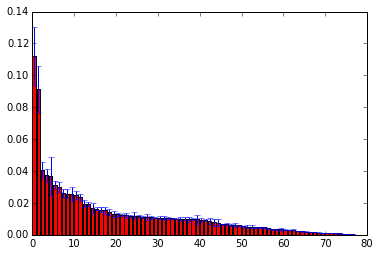

In [96]:
# Feature selection
y_train = train_wide_common['TripType'].values
X_train = train_wide_common.drop(['TripType', 'VisitNumber'], axis = 1).values
clf = ensemble.ExtraTreesClassifier()
clf.fit(X_train, y_train)
important_features = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis = 0)
indices = np.argsort(important_features)[::-1] # sort in descending order
col_names = train_wide_common.drop(['TripType', 'VisitNumber'], axis = 1).columns.values

for col in range(X_train.shape[1]):
    print col, indices[col], col_names[indices[col]],  important_features[indices[col]]
plt.bar(range(X_train.shape[1]), important_features[indices], yerr= std[indices], color = 'red')

In [97]:
top_features = col_names[indices][0:20]
top_features_w_TripType = ['TripType'] + list(top_features)
print train_wide_common.shape
train_wide_common = train_wide_common[top_features_w_TripType]
print train_wide_common.shape
y_train = train_wide_common['TripType'].values
X_train = train_wide_common.drop(['TripType'], axis = 1).values

clf = linear_model.logistic.LogisticRegression(C = 1, n_jobs = -1)
scores = cross_validation.cross_val_score(clf, X_train, y_train, cv = 5)
print scores, scores.mean()

(95674, 80)
(95674, 21)
[ 0.56760144  0.56863769  0.5623661   0.5688294   0.56923157] 0.567333241829


In [98]:
test_wide_common_orig = test_wide_common.copy()
test_wide_common = test_wide_common[top_features]
X_test = test_wide_common.values
clf.fit(X_train, y_train)
predicted_proba = clf.predict_proba(X_test)
print predicted_proba.shape

(95674, 38)


In [99]:
unique_trip_types =  np.sort(train_wide_common['TripType'].unique())
unique_trip_types =  ['TripType_'+ str(t) for t in unique_trip_types]
print unique_trip_types

unique_visits = test_wide_common_orig['VisitNumber']
df_predicted = pd.DataFrame(predicted_proba, columns = unique_trip_types)
df_predicted = pd.concat([unique_visits, df_predicted], axis = 1)
print df_predicted.shape
df_predicted.to_csv('./data/test_predicted.csv', index = False)


['TripType_3', 'TripType_4', 'TripType_5', 'TripType_6', 'TripType_7', 'TripType_8', 'TripType_9', 'TripType_12', 'TripType_14', 'TripType_15', 'TripType_18', 'TripType_19', 'TripType_20', 'TripType_21', 'TripType_22', 'TripType_23', 'TripType_24', 'TripType_25', 'TripType_26', 'TripType_27', 'TripType_28', 'TripType_29', 'TripType_30', 'TripType_31', 'TripType_32', 'TripType_33', 'TripType_34', 'TripType_35', 'TripType_36', 'TripType_37', 'TripType_38', 'TripType_39', 'TripType_40', 'TripType_41', 'TripType_42', 'TripType_43', 'TripType_44', 'TripType_999']
(95674, 39)
